In [1]:
import numpy as np
import pandas as pd

from tqdm import tqdm

import keras
from keras.models import Model
from keras import applications
from keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.losses import CategoricalCrossentropy
from keras.optimizers import Adam, RMSprop

from keras.utils import load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from matplotlib import image as mpimg

In [2]:
landmarks_dict = {
    0: 'Other',
    1: 'Crater',
    2: 'Dark Dune',
    3: 'Slope Streak',
    4: 'Bright Dune',
    5: 'Impact Ejecta',
    6: 'Swiss Cheese',
    7: 'Spider'
}

landmarks_dict_reversed = {
    'Other': 0,
    'Crater': 1,
    'Dark Dune': 2,
    'Slope Streak': 3,
    'Bright Dune': 4,
    'Impact Ejecta': 5,
    'Swiss Cheese': 6,
    'Spider': 7
}

### Prepare Data

In [3]:
train_images = []
train_labels = []

cv_images = []
cv_labels = []

test_images = []
test_labels = []

labels_map_file = open('Data/labels-map-proj_v3_2_train_val_test.txt', 'r')

labels_list = [line.strip() for line in labels_map_file.readlines()]

for line in tqdm(labels_list):
    file_name, label, t_v_t = line.split(' ')[0], line.split(' ')[1], line.split(' ')[2]

    label = landmarks_dict[int(label)]

    if t_v_t == 'train':
        train_images.append('Data/map-proj-v3_2/' + file_name)
        train_labels.append(label)
    
    elif t_v_t == 'val':
        cv_images.append('Data/map-proj-v3_2/' + file_name)
        cv_labels.append(label)

    else:
        test_images.append('Data/map-proj-v3_2/' + file_name)
        test_labels.append(label)

train_df = pd.DataFrame({'images': train_images, 'labels': train_labels})
cv_df = pd.DataFrame({'images': cv_images, 'labels': cv_labels})
test_df = pd.DataFrame({'images': test_images, 'labels': test_labels})

100%|██████████| 67810/67810 [00:00<00:00, 1073267.00it/s]


### Random Set of Images from the Dataset

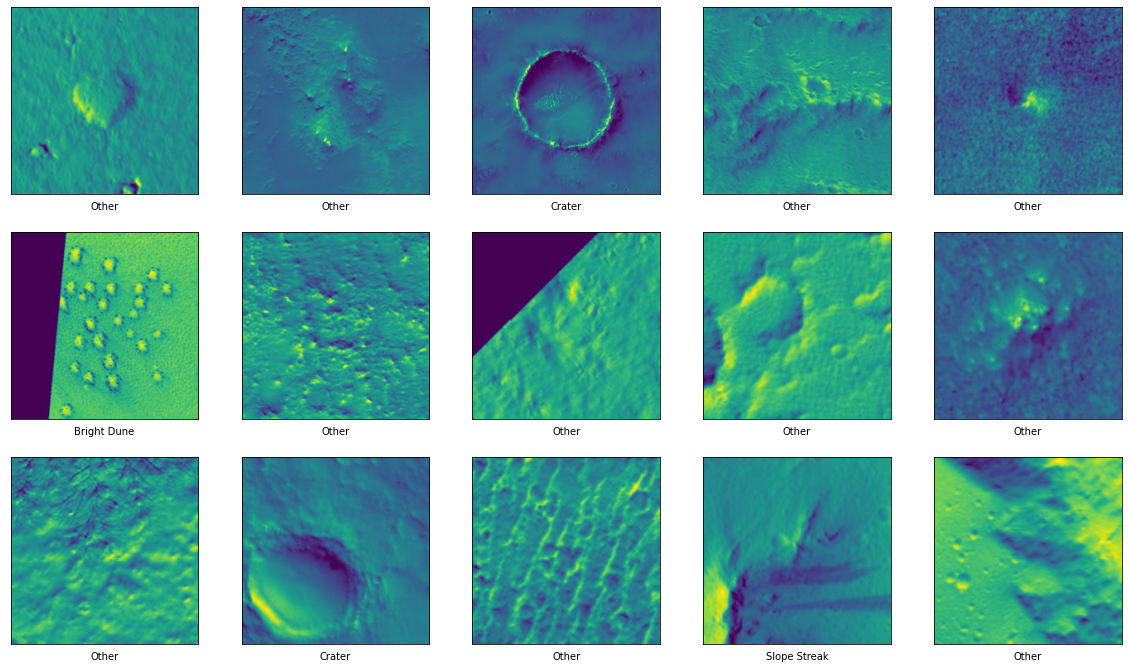

In [4]:
plt.figure(figsize=(20, 20))

for i in range(15):
    ax = plt.subplot(5, 5, i + 1)
    # ax.xaxis.label.set_color('white')

    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    random_sample = train_df.sample()
    random_image, random_label = random_sample.images.iloc[0], random_sample.labels.iloc[0]
    plt.imshow(mpimg.imread(random_image))
    plt.xlabel(random_label)

plt.show()

### Countplot Bar

#### Training Dataset Distribution

<AxesSubplot:xlabel='labels', ylabel='count'>

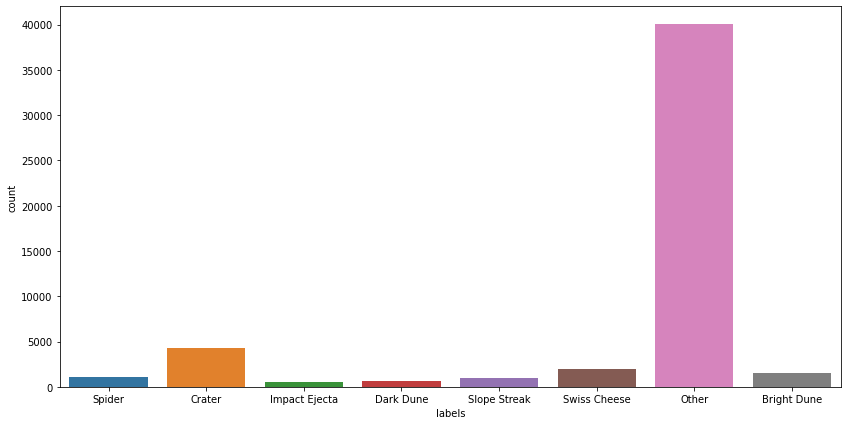

In [5]:
sns.countplot(data=train_df, x='labels', ax=plt.subplots(figsize=(14, 7))[1])

#### Cross Validation Dataset Distribution

<AxesSubplot:xlabel='labels', ylabel='count'>

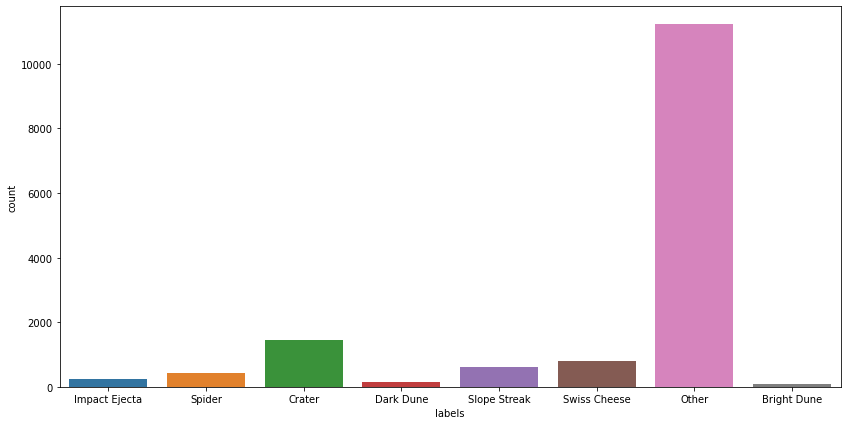

In [6]:
sns.countplot(data=cv_df, x='labels', ax=plt.subplots(figsize=(14, 7))[1])

#### Test Dataset Distribution

<AxesSubplot:xlabel='labels', ylabel='count'>

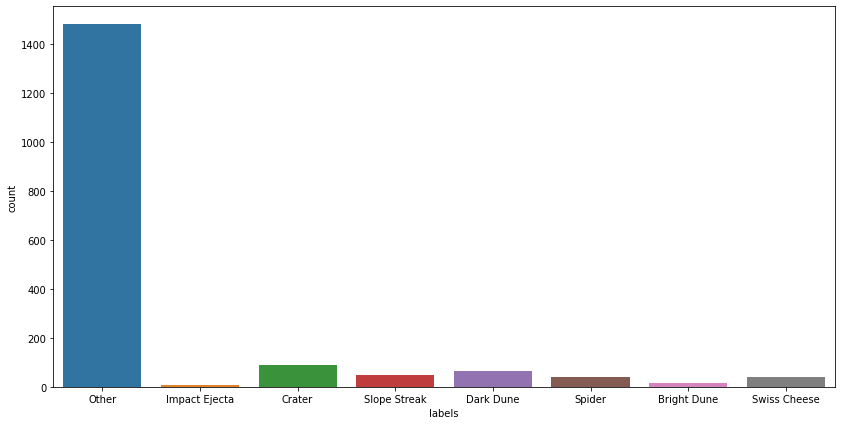

In [7]:
sns.countplot(data=test_df, x='labels', ax=plt.subplots(figsize=(14, 7))[1])

In [8]:
BATCH_SIZE = 32

In [9]:
datagen = ImageDataGenerator()

In [10]:
training_iterator = datagen.flow_from_dataframe(
    train_df,
    x_col='images',
    y_col='labels',
    target_size=(227, 227),
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    classes=landmarks_dict_reversed
)

Found 51058 validated image filenames belonging to 8 classes.


In [11]:
cv_iterator = datagen.flow_from_dataframe(
    cv_df,
    x_col='images',
    y_col='labels',
    target_size=(227, 227),
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    classes=landmarks_dict_reversed
)

Found 14959 validated image filenames belonging to 8 classes.


In [12]:
test_iterator = datagen.flow_from_dataframe(
    test_df,
    x_col='images',
    y_col='labels',
    target_size=(227, 227),
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    classes=landmarks_dict_reversed
)

Found 1793 validated image filenames belonging to 8 classes.


### Input Preprocessing

In [13]:
inputs = Input(shape=(227, 227, 3))
x = applications.resnet_v2.preprocess_input(inputs)

### Model Bulding Using Pretrained Model ResNet50V2

In [14]:
base_model = applications.ResNet50V2(
    include_top=False,
    weights='imagenet',
    input_shape=(227, 227, 3),
    classes=8
)

#### Freezing Pre-Trained Weights of Base Model

In [15]:
base_model.trainable = False

#### Rebuilding the Top Layers

The top layers include the following:
 - GlobalAveragePooling2D - performs downsampling by computing the mean of the height and width dimensions of the input.
 - BatchNormalization - a technique used to improve the performance and stability of neural networks. It is a normalization method that is applied to the activations of hidden layers in a neural network.
 - Dropout - a regularization technique for reducing overfitting in neural networks (in this case the probability rate is set to 0.2).

In [16]:
x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

outputs = Dense(8, activation='softmax')(x)

In [17]:
model = Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 227, 227, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 227, 227, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 227, 227, 3)      0         
 a)                                                              
                                                                 
 resnet50v2 (Functional)     (None, 8, 8, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                             

### Model Training

#### Compiling the Model

In [18]:
model.compile(loss=CategoricalCrossentropy(), optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

#### Using early stopping callback method to avoid overfitting during training

In [19]:
es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)

In [20]:
history = model.fit(
        training_iterator,
        validation_data=cv_iterator,
        epochs=30,
        batch_size=BATCH_SIZE,
        callbacks=[es]
)

Epoch 1/30
1596/1596 [==============================] - 685s 420ms/step - loss: 0.6010 - accuracy: 0.8244 - val_loss: 0.4361 - val_accuracy: 0.8638
Epoch 2/30
1596/1596 [==============================] - 150s 94ms/step - loss: 0.2072 - accuracy: 0.9330 - val_loss: 0.3950 - val_accuracy: 0.8755
Epoch 3/30
1596/1596 [==============================] - 150s 94ms/step - loss: 0.1667 - accuracy: 0.9442 - val_loss: 0.3862 - val_accuracy: 0.8799
Epoch 4/30
1596/1596 [==============================] - 150s 94ms/step - loss: 0.1444 - accuracy: 0.9499 - val_loss: 0.3836 - val_accuracy: 0.8831
Epoch 5/30
1596/1596 [==============================] - 150s 94ms/step - loss: 0.1296 - accuracy: 0.9547 - val_loss: 0.3865 - val_accuracy: 0.8820
Epoch 6/30
1596/1596 [==============================] - 152s 95ms/step - loss: 0.1200 - accuracy: 0.9579 - val_loss: 0.3898 - val_accuracy: 0.8850
Epoch 7/30
1596/1596 [==============================] - 152s 95ms/step - loss: 0.1130 - accuracy: 0.9594 - val_loss: 

### Evaluating Model Performance

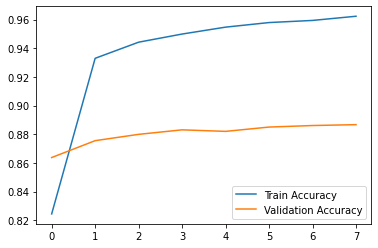

In [21]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')

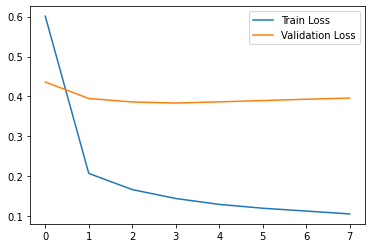

In [22]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

#### Model Training Evaluation - Accuracy and Loss

In [32]:
model.evaluate(training_iterator, batch_size=BATCH_SIZE)

1596/1596 [==============================] - 136s 85ms/step - loss: 0.0839 - accuracy: 0.9693


[0.08391625434160233, 0.9692898392677307]

#### Model Cross Validation Evaluation - Accuracy and Loss

In [24]:
model.evaluate(cv_iterator, batch_size=BATCH_SIZE)

468/468 [==============================] - 35s 76ms/step - loss: 0.3960 - accuracy: 0.8867


[0.3960331380367279, 0.8866902589797974]

#### Model Test Evaluation - Accuracy and Loss

In [25]:
model.evaluate(test_iterator, batch_size=BATCH_SIZE)

57/57 [==============================] - 13s 232ms/step - loss: 0.3445 - accuracy: 0.9247


[0.3444833755493164, 0.9247071743011475]

In [26]:
y_pred = model.predict(test_iterator, batch_size=BATCH_SIZE)
y_pred = np.argmax(y_pred, axis=1)

57/57 [==============================] - 4s 72ms/step


#### Precision / Recall Results

In [27]:
y_test = test_df.labels.copy()
y_test = y_test.apply(lambda label : landmarks_dict_reversed[label])

report = classification_report(y_test, y_pred, target_names=list(landmarks_dict.values()), output_dict=True)
report = pd.DataFrame(report).transpose().reset_index()
report.rename(columns={'index': 'landmarks'}, inplace=True)

report = report.head(8)
report

,landmarks,precision,recall,f1-score,support
0,Other,0.822654,0.857625,0.839775,1482.0
1,Crater,0.013699,0.011236,0.012346,89.0
2,Dark Dune,0.015873,0.015152,0.015504,66.0
3,Slope Streak,0.057143,0.040816,0.047619,49.0
4,Bright Dune,0.000000,0.000000,0.000000,16.0
5,Impact Ejecta,0.000000,0.000000,0.000000,7.0
6,Swiss Cheese,0.023256,0.023810,0.023529,42.0
7,Spider,0.000000,0.000000,0.000000,42.0


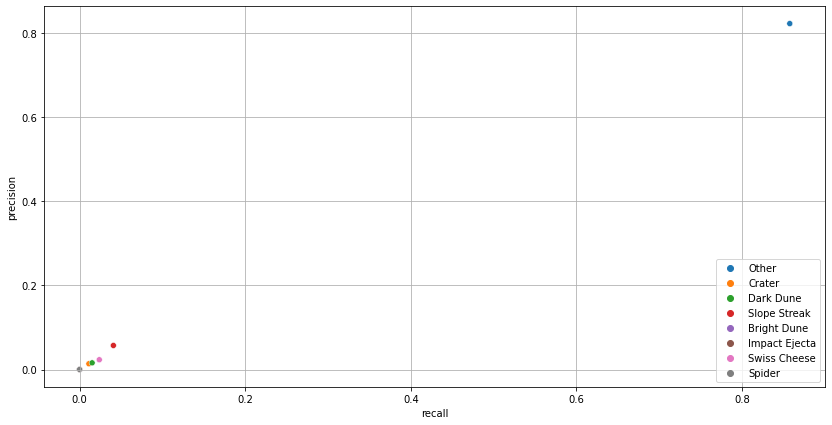

In [28]:
sns.scatterplot(data=report, x='recall', y='precision', hue='landmarks', ax=plt.subplots(figsize=(14, 7))[1])

plt.legend(loc='lower right')
plt.grid()

#### Confusion Matrix

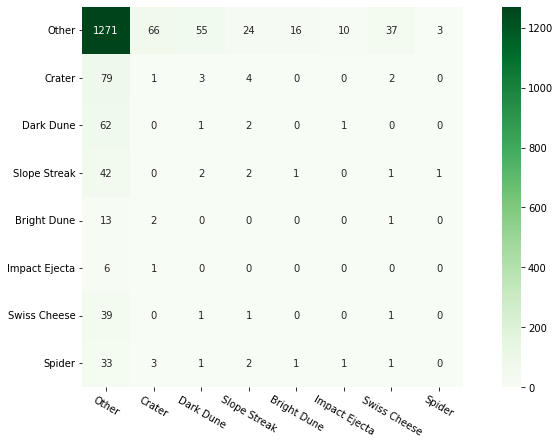

In [29]:
conf = confusion_matrix(y_test, y_pred)

sns.heatmap(conf, cmap=plt.cm.get_cmap('Greens'), annot=True, square=True, fmt='d', xticklabels=list(landmarks_dict.values()),
yticklabels=list(landmarks_dict.values()), ax=plt.subplots(figsize=(14, 7))[1]).tick_params(axis='x', rotation=-30)

### Predictions

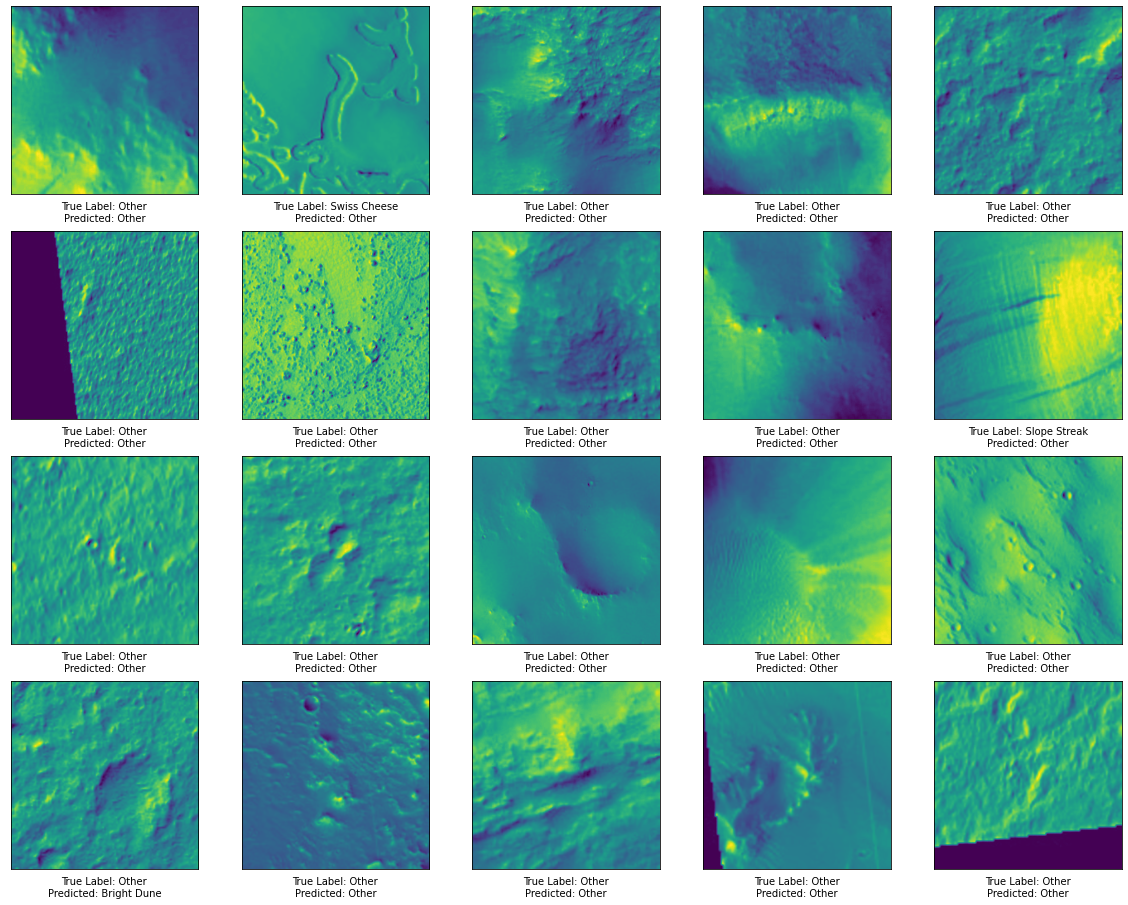

In [30]:
plt.figure(figsize=(20, 20))

for i in range(20):
    ax = plt.subplot(5, 5, i + 1)
    # ax.xaxis.label.set_color('white')
    
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    random_sample = test_df.sample()

    random_image = random_sample.images.iloc[0]
    
    y_true = random_sample.labels.iloc[0]
    y_hat = landmarks_dict[y_pred[list(random_sample.images.index)[0]]]

    plt.imshow(mpimg.imread(random_image), None)
    plt.xlabel(f'True Label: {y_true}\nPredicted: {y_hat}')

plt.show()

#### Conclusion
The classes in this dataset are highly imbalanced. Most of the images classified as "Other" including data augmentation has roughly 53 thousand images, while
other images from different classes have at most approximately 6 thousand. We applied transfer learning technique using a pre-trained model ResNet50V2 with "ImageNet" weights. The model includes
20,488 trainable parameters and 23,568,896 non-trainable (frozen) parameters. The model gives a fairly good performance on the class "Other" with an f1-score of 0.84.
However, on other categories such as Crater, Dark Dune, Slope Streak and Swiss Cheese the model gives a very poor performance: f1-score of at most 0.05 on class Slope Streak.
Classes such as "Bright Dune", "Impact Ejecta" and "Spider" were classified incorrectly 100% of the time (shown in the confusion matrix).
The best way to improve performance on the less common classes is to increase their representation in the entire dataset.

In [31]:
model.save('Models/ResNet50V2/')

INFO:tensorflow:Assets written to: Models/ResNet50V2/assets


INFO:tensorflow:Assets written to: Models/ResNet50V2/assets


#### Acknowledgements:
The data used in this project comes from the DOI: <br>
10.5281/zenodo.2538135

Gary Doran, Emily Dunkel, Steven Lu, & Kiri Wagstaff. (2020). Mars orbital image (HiRISE) labeled data set version 3.2 (3.2.0) [Data set]. Zenodo. https://doi.org/10.5281/zenodo.4002935

Idea for this project and the data originates from the following paper: <br>
Kiri Wagstaff, Steven Lu, Emily Dunkel, Kevin Grimes, Brandon Zhao, Jesse Cai,
Shoshanna B. Cole, Gary Doran, Raymond Francis, Jake Lee, and Lukas Mandrake "Mars Image Content Classification: Three Years of NASA Deployment and Recent Advances" The Thirty-Fifth AAAI Conference on Artificial Intelligence (AAAI-21)